<h2>说明：</h2>


这个学习代码来自于Google的COLAB, 原链接点击[here](https://colab.research.google.com/notebooks/mlcc/first_steps_with_tensor_flow.ipynb?utm_source=mlcc&utm_campaign=colab-external&utm_medium=referral&utm_content=firststeps-colab&hl=en#scrollTo=Bd2Zkk1LE2Zr).
<br>

<h2>课程目的：</h2><br>

    
1、了解Tensorflow的基本概念<br>
2、用TEnsorflow自带的逻辑回归算法预测房价中位数<br>
3、利用均方根误差RMSE来评估模型预测准确度<br>
（如果不清楚RMSE是什么，请点击[此处](https://blog.csdn.net/sxb0841901116/article/details/83097165)看我的另一篇博客) <br>
4、通过调整超参数来提高模型的准确度<br>


<h2>环境安装</h2>


In [1]:
# first install package 
'''
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install sklearn
!pip install tensorflow 

'''

'\n!pip install numpy\n!pip install pandas\n!pip install matplotlib\n!pip install sklearn\n!pip install tensorflow \n\n'

In [2]:

from __future__ import print_function

import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format



<strong>如果报如下错误：</strong> <br>
ModuleNotFoundError                       Traceback (most recent call last)
ModuleNotFoundError: No module named 'numpy.core._multiarray_umath'
<br>
请执行命令：<br>
!pip install --upgrade --force-reinstall numpy==1.14.5
!pip install --upgrade --force-reinstall pandas==0.22.0


In [3]:
# load data from local file whose name is california_housing_train.csv from the below remote url
# https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv
california_housing_dataframe = pd.read_csv("california_housing_train.csv", sep=",")

# random the data for better splitting the train and test dataset 
california_housing_dataframe.reindex(np.random.permutation(california_housing_dataframe.index))

# we'll scale median_house_value to be in units of thousands for future training
california_housing_dataframe['median_house_value'] /= 1000.0
california_housing_dataframe.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0
mean,-119.6,35.6,28.6,2643.7,539.4,1429.6,501.2,3.9,207.3
std,2.0,2.1,12.6,2179.9,421.5,1147.9,384.5,1.9,116.0
min,-124.3,32.5,1.0,2.0,1.0,3.0,1.0,0.5,15.0
25%,-121.8,33.9,18.0,1462.0,297.0,790.0,282.0,2.6,119.4
50%,-118.5,34.2,29.0,2127.0,434.0,1167.0,409.0,3.5,180.4
75%,-118.0,37.7,37.0,3151.2,648.2,1721.0,605.2,4.8,265.0
max,-114.3,42.0,52.0,37937.0,6445.0,35682.0,6082.0,15.0,500.0


<h2>模型训练 </h2>

我们这个模型主要是预测房子的median_house_value，那么这个数据就是我们的目标值。为了方面观察，我们只选择其中的一个特征，total_rooms.由于我们这个数据是基于城市中的街区的，那么这个total_rooms这个特征就这个街区的房子总数

<h3> 第一步: 定义特征和配置特征列</h3>

  为了将我们的数据映射到tensorflow, 我们需要指定特征的数据类型，一般在tensorflow中由2种数据类型：分类类型和数值类型，分类类型一般用one-hot方式进行编码，如果特征是浮点或者整型，一般都用数值类型。由于我们total_rooms是数值，我们就用数值类型

In [30]:
# pull the feature data from california_housing_dataframe
my_feature = california_housing_dataframe[['total_rooms']]

<h5>备注： 在california_housing_dataframe用'[[]]'则把数据转化为17000 x 1的dataframe格式了，如果用'[]'则返回结果是Series了</h5>

In [31]:
my_feature


,total_rooms
0,5612.0
1,7650.0
2,720.0
3,1501.0
4,1454.0
...,...
16995,2217.0
16996,2349.0
16997,2677.0
16998,2672.0


In [32]:
# define feature columns using numeric_column, which specifies its data is numberic 
feature_columns = [tf.feature_column.numeric_column('total_rooms')]
feature_columns

[NumericColumn(key='total_rooms', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)]

<h3> 第二步: 定义目标</h3>

In [24]:
targets = california_housing_dataframe['median_house_value']
targets

0        66.9
1        80.1
2        85.7
3        73.4
4        65.5
         ... 
16995   111.4
16996    79.0
16997   103.6
16998    85.8
16999    94.6
Name: median_house_value, Length: 17000, dtype: float64

<h3> 第三步: 选择线性回归模型(LinearRegressor)</h3>

我们使用线性回归模型，主要用梯度下降法来训练模型，不了解梯度下降法的可以点击[此处](https://mp.csdn.net/postedit/83303065)，在tensorflow已经有实现的优化器GradientDescentOptimizer。 此外，为了防止在模型训练中防止梯度爆炸式的降低，一般通过clip_gradients_by_norm来限制。 

In [33]:
# Use gradient descent as the optimizer for training the model 
my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.0000001)
my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(clip_norm=5, optimizer=my_optimizer)

# Define the model with our feature column and my optimizer 
linear_regressor = tf.estimator.LinearRegressor(
    optimizer=my_optimizer,
    feature_columns=feature_columns
)

<h3> 第四步: 定义输入函数</h3>

输入函数input_function主要是用来把我们的数据导入到模型中，在这个函数中我们可以根据模型的需要对数据进行预处理，比如批量处理、随机打乱、重复等等。把数据处理成tensorflow数据需要的格式。 这个模型中训练数据主要分为以下几步：<br>
1、我们把pandas中dataframe数据转换为numpy数组的字典形式，然后调用tensorflow的数据接口构造tensorflo需要的dataset对象，根据批量训练大小（batch_size）分为若干份，并确定要迭代的具体次数<br>
2、根据参数shuffle是否True，我们看在模型训练过程中是否需要将数据打乱，buffer_size参数指定shuffle随机抽样的数据集的大小。<br>
3、我们的输入方法生成一个迭代器，每次生成模型下次训练时候的数据集<br>

In [39]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """
    train the data into tensorflow dataset
    Args: 
        features: dataframe in pandas
        targets: dataframe in pandas
        batch_size: the number of samples in every interation
        suffle: randamly suffle the data if Ture
        repeat: whether to repeat data, None=never ininfinitely
    """
    # Covert pandas data into a dict of numpy array
    features = {key:np.array(value) for key,value in dict(features).items()} 
    
    # Construct a dataset, and configure batching/repeating.
    ds = Dataset.from_tensor_slices((features, targets))
    ds.batch(batch_size).repeat(num_epochs)

    # Suffle the data, if specified
    if shuffle:
        ds = ds.shuffle(buffer_size=10000)
    
    # Return the next batch of data
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels


<h3> 第五步: 训练模型</h3>

在tensorflow中训练模型一般用方法train,把输入函数作为参数传递进去

In [54]:
_ = linear_regressor.train(input_fn=lambda:my_input_fn(my_feature, targets), 
                            steps=100)


<h3> 第六步: 评估模型</h3>

在模型训练过程中，我们要了解训练的情况，看看我们的模型能否在训练集上表现良好。 所以我们在训练中打印出均方误差和均方根误差，来观察模型的泛化能力。 在后期的练习中，我们会把数据分为训练集和测试集，更能反馈模型的普适性。


In [61]:
# Create an input function for prediction 
prediction_input_fn = lambda: my_input_fn(my_feature, targets, num_epochs=1, shuffle=False)

# Call predict() on the linear_regressor to make predictions 
predictions = linear_regressor.predict(input_fn=prediction_input_fn)

# Format the prediction as the numpy array , so we could calculate the error metrics. 
predictions = np.array([item['predictions'][0] for item in predictions])


# Print mean square error and root mean square error. 
mean_squared_error = metrics.mean_squared_error(predictions, targets)
root_mean_squared_error = math.sqrt(mean_squared_error)
print("Mean Squared Error (on training data): %0.3f" % mean_squared_error)
print("Root Mean Squared Error (on training data): %0.3f" % root_mean_squared_error)

Mean Squared Error (on training data): 56193.121
Root Mean Squared Error (on training data): 237.051


我们得到的均方根误差为237和均方差误差为56193，那么这个数字能说明我们的模型好坏吗？ 
我们选择用RMSE，因为MSE和我们的数据不在一个量纲上。 利用这个值我们和最大最小值的差距进行比较


In [64]:

min_house_value =  california_housing_dataframe["median_house_value"].min()
max_house_value = california_housing_dataframe["median_house_value"].max()
min_max_difference = max_house_value - min_house_value

print("Min. Median House Value: %0.3f" % min_house_value)
print("Max. Median House Value: %0.3f" % max_house_value)
print("Difference between Min. and Max.: %0.3f" % min_max_difference)
print("Root Mean Squared Error: %0.3f" % root_mean_squared_error)

Min. Median House Value: 14.999
Max. Median House Value: 500.001
Difference between Min. and Max.: 485.002
Root Mean Squared Error: 237.051


可以看出是我们差距的一般，一般来说，这个RMSE是比较大。
我们也可以看看平均值

In [65]:
df = pd.DataFrame()
df['predictions'] = pd.Series(predictions)
df['target'] = pd.Series(targets)
df.describe()

,predictions,target
count,17000.0,17000.0
mean,0.5,207.3
std,0.4,116.0
min,0.0,15.0
25%,0.3,119.4
50%,0.4,180.4
75%,0.6,265.0
max,7.6,500.0


一般来说，我们RMSE和平均值相比，越小越好。我们也可以绘制样本线，看看模型分布

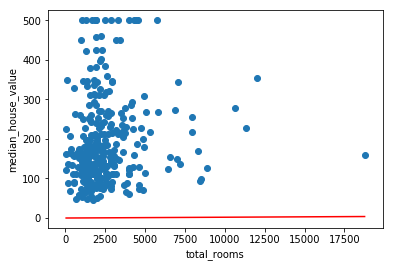

In [62]:
sample = california_housing_dataframe.sample(n=300)

# Get the min and max total_rooms values.
x_0 = sample["total_rooms"].min()
x_1 = sample["total_rooms"].max()

# Retrieve the final weight and bias generated during training.
weight = linear_regressor.get_variable_value('linear/linear_model/total_rooms/weights')[0]
bias = linear_regressor.get_variable_value('linear/linear_model/bias_weights')

# Get the predicted median_house_values for the min and max total_rooms values.
y_0 = weight * x_0 + bias 
y_1 = weight * x_1 + bias

# Plot our regression line from (x_0, y_0) to (x_1, y_1).
plt.plot([x_0, x_1], [y_0, y_1], c='r')

# Label the graph axes.
plt.ylabel("median_house_value")
plt.xlabel("total_rooms")

# Plot a scatter plot from our data sample.
plt.scatter(sample["total_rooms"], sample["median_house_value"])

# Display graph.
plt.show()

我们可以看出这个线相对数据来说，比较遥远。 通过上面的一些方法，我们就可以对模型做一个基本健康性的检查。 

<h3>封装我们的模型，进行调整超参数</h3>

In [79]:
def train_model(learning_rate=0.000001, steps=100, input_feature='total_rooms', batch_size=1 ):
    """
    Trains a linear regression model of one feature.
    Args:
        learning_rate: A float, the learning rate
        steps: a non-zero 'int',the total number of training steps. 
        input_feature: A `string` specifying a column from `california_housing_dataframe` to use as input feature.
        batch_size: A non-zero `int`, the batch size.
    """
    periods = 10 
    steps_per_period = steps / periods
    my_label = "median_house_value"
    my_feature = input_feature
    
    # extract the feature and targets from dataframe
    features_data = california_housing_dataframe[[my_feature]]
    targets = california_housing_dataframe[my_label]
    
    # define the model with feature_columns and optimizer 
    feature_columns = [tf.feature_column.numeric_column(my_feature)]
    my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
    my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(clip_norm=5, optimizer=my_optimizer)
    linear_regressor = tf.estimator.LinearRegressor(optimizer=my_optimizer, 
                                                   feature_columns=feature_columns
                                                   )
    
    # define the input function for training and prediction 
    training_input_fn  = lambda: my_input_fn(features=features_data, targets=targets, batch_size=batch_size)
    prediction_input_fn  = lambda: my_input_fn(features=features_data, targets=targets, batch_size=batch_size, num_epochs=1,
                                              shuffle=False)
    

    # Set up to plot the state of our model's line each period.
    plt.figure(figsize=(15, 6))
    plt.subplot(1, 2, 1)
    plt.title("Learned Line by Period")
    plt.ylabel(my_label)
    plt.xlabel(my_feature)
    sample = california_housing_dataframe.sample(n=300)
    plt.scatter(sample[my_feature], sample[my_label])
    colors = [cm.coolwarm(x) for x in np.linspace(-1, 1, periods)]
    
    # Train the model, but do so inside a loop so that we can periodically assess
    # loss metrics.
    print("Training model...")
    print("RMSE (on training data):")
    root_mean_squared_errors = []
    for period in range(0, periods):
        linear_regressor.train(input_fn=training_input_fn, 
                               steps=steps_per_period
                              )
        
        # Call predict() on the linear_regressor to make predictions 
        predictions = linear_regressor.predict(input_fn=prediction_input_fn)

        # Format the prediction as the numpy array , so we could calculate the error metrics. 
        predictions = np.array([item['predictions'][0] for item in predictions])
        
        # Print mean square error and root mean square error. 
        mean_squared_error = metrics.mean_squared_error(predictions, targets)
        root_mean_squared_error = math.sqrt(mean_squared_error)
        root_mean_squared_errors.append(root_mean_squared_error)
        
        # Occasionally print the current losss
        print('Period: %02d : %0.2f' % (period, root_mean_squared_error))
        
        
        # Finally, track the weights and biases over time.
        # Apply some math to ensure that the data and line are plotted neatly.
        y_extents = np.array([0, sample[my_label].max()])

        weight = linear_regressor.get_variable_value('linear/linear_model/%s/weights' % input_feature)[0]
        bias = linear_regressor.get_variable_value('linear/linear_model/bias_weights')

        x_extents = (y_extents - bias) / weight
        x_extents = np.maximum(np.minimum(x_extents,
                                          sample[my_feature].max()),
                               sample[my_feature].min())
        y_extents = weight * x_extents + bias
        plt.plot(x_extents, y_extents, color=colors[period]) 
                
    print("Model training finished.")
    print("Final RMSE (on training data): %0.2f" % root_mean_squared_error)
    
    # Output a graph of loss metrics over periods.
    plt.subplot(1, 2, 2)
    plt.ylabel('RMSE')
    plt.xlabel('Periods')
    plt.title("Root Mean Squared Error vs. Periods")
    plt.tight_layout()
    plt.plot(root_mean_squared_errors)


    # Output a table with calibration data.
    calibration_data = pd.DataFrame()
    calibration_data["predictions"] = pd.Series(predictions)
    calibration_data["targets"] = pd.Series(targets)
    display.display(calibration_data.describe())



Training model...
RMSE (on training data):
Period: 00 : 225.63
Period: 01 : 214.42
Period: 02 : 204.04
Period: 03 : 194.62
Period: 04 : 187.86
Period: 05 : 181.89
Period: 06 : 175.66
Period: 07 : 171.74
Period: 08 : 169.46
Period: 09 : 168.27
Model training finished.
Final RMSE (on training data): 168.27


,predictions,targets
count,17000.0,17000.0
mean,111.1,207.3
std,91.6,116.0
min,0.1,15.0
25%,61.5,119.4
50%,89.4,180.4
75%,132.5,265.0
max,1594.6,500.0


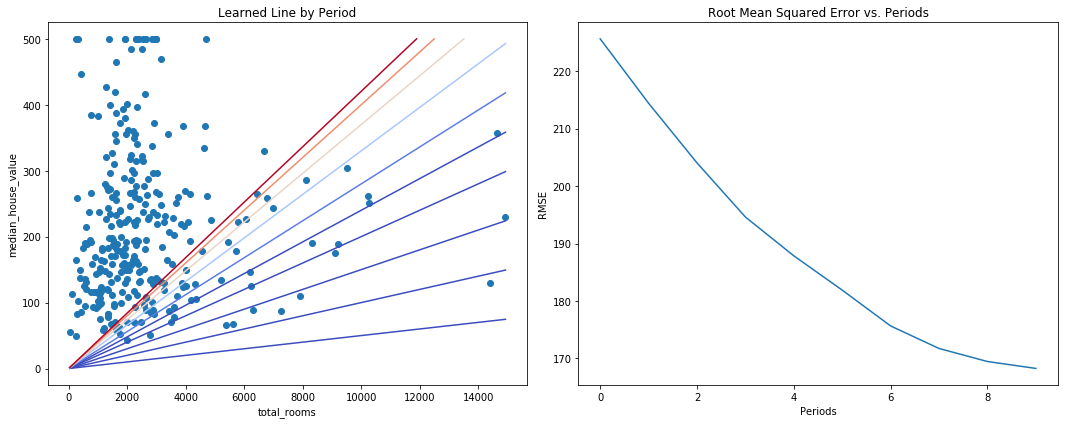

In [83]:
train_model(
    learning_rate=0.0001,
    steps=100,
    batch_size=10 
)

在上面不断调节超参数，就会看到不同曲线。 如果RMSE是一条不断下降的曲线，那么说明模型的效果会更好。 

一些调参经验（来自于Google）
模型调整是否有标准启发式？<br>
这是一个常见问题。简而言之，不同超参数的影响是与自己的数据有关。一些通用调整参数的规则：<br>
训练误差应该首先急剧下降，并且随着训练收敛，最终应该稳定下来。<br>
如果训练没有收敛，请尝试延长训练时间。<br>
如果训练误差减慢得太慢，提高学习率可能会帮助它更快地减少。<br>
但是，如果学习率太高，有时可能会发生完全相反的情况。如果训练误差变化很大，请尝试降低学习率。<br>
较低的学习率加上较大的步骤数或较大的批量大小通常是一个很好的组合。
非常小的批量大小也会导致不稳定。首先尝试更大的值，如100或1000，并减少直到看到退化。<br>
同样，永远不要严格遵循这些经验法则，因为效果与数据有关。始终进行实验和验证。<br>